# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name="Banana_Windows_x86_64/Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:
        print("\rFinal Score = {:3d}".format(int(score)))
        break
    else:
        print("\rScore: {:3d}".format(int(score)), end="")

Final Score =   0


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

#### A. Import Double DQN Agent and Training/Testing Code

The agent uses a trained DQN ([Deep-Q Network](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf)) to select actions to try to increase the final scores. The [Double Q-Learning](https://arxiv.org/abs/1509.06461) and [Prioritized Experience Replay](https://arxiv.org/abs/1511.05952) algorithms are used for training the DQN model. So the agent is a Double DQN agent.

The input to the DQN is the observed external state vector provided by the environment. Since no state history information is used, this DQN model doesn't handle repeated states after a short sequence of actions very well. If the state is repeated, the Q-values obtained by the DQN will also be repeated and this will cause the agent to loop through the same sequence of actions forever.

To help alleviate the problem caused by repeated states, a method of tracking a short history of observed external states and the simulated internal states (x-y positions and orientations) is developed. Tracking simulated internal states is kind of like using odometry with orientation information to track the position and orientation of the agent. Unlike odometry that uses wheel rotation for tracking, simulated state tracking is based on the actions taken by the agent. This history is used to post-process the actions ranked by the Q-values from the DQN to avoid undesirable actions causing repeated states to improve the final scores. An alternative is to incorporate the history into the external state vector by augmenting it with indicator vectors identifying the undesirable actions to be avoided. In training such a DQN with augmented state vectors as inputs, the rewards stored in the experience replay buffer are modified by penalty values to discourage the undesirable actions. The rewards are only modified within the process of DQN training and the original reward defined by the environment is not modified.

The code for DQN with Double Q-Learning (Double DQN) and Prioritized Experience Replay support and the methods for alleviating the problem caused by repeated states is developed in the `ddqn_agent` module. The code for experimenting with various options for training and testing the DQN model is in the `train_test` module. Parameter `tor_dstate` is used to determine whether the vector norm of the difference of two states is small enough for them to be considered essentially the same.

In [6]:
from ddqn_agent import DDQNPERAgent
import train_test as tt
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Tolerance for detecting whether two states are different.
tor_dstate = 1e-3

#### B. Test for Repeated States

Compare states separated by a certain number of actions to check whether they are essentially the same. The vector norm of the state difference is calculated.

State Deltas: Max = 1.10e+01, Min = 0.00e+00


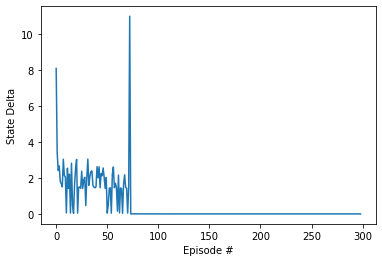

In [7]:
# The agent always takes the backward action. It will eventually back onto a wall and be stuck there. If the action
# selected by the DQN model is backward in such a stucked situation, the backward action will be selected again and
# again since the input to the model, the state, is essentially the same as illustrated here.

actions = [1]
tt.test_repeat_states(env, actions)

State Deltas: Max = 2.49e+00, Min = 0.00e+00


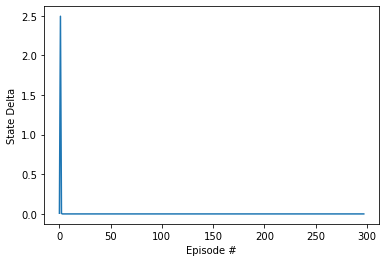

In [8]:
# The agent takes a right turn and then a left turn. As shown here, the state keeps repeating itself after these
# two actions. If the DQN model first selects a right turn and then a left turn, it will likely keep selecting a
# right turn followed by a left turn since the input states to the model are essentially the same. The same will
# happen for two opposite move actions (e.g., forward followed by backward).

actions = [3, 2]
tt.test_repeat_states(env, actions)

State Deltas: Max = 4.10e+00, Min = 6.23e-07


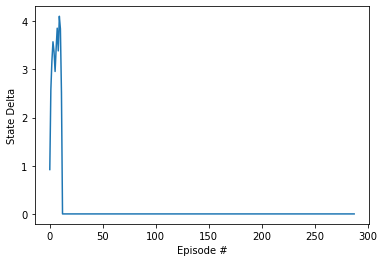

In [9]:
# The agent takes 12 consecutive left turns and the state is repeated. This shows the angular span for each
# turn is one-twelfth of a circle.

actions = [2] * 12
tt.test_repeat_states(env, actions)

#### C. Experiment with Double DQN Model with Prioritized Experience Replay

##### Train the model

The model is implemented by a fully-connected neural network with two hidden layers with both sizes set to 64. The environment is considered solved when the average score for 100 episodes is 13 or more.

Episode  200	Average Score:   0.31
Episode  400	Average Score:   4.92
Episode  600	Average Score:   9.07
Episode  800	Average Score:  12.00
Episode 1000	Average Score:  13.02 (Best Solved Average Score:  13.14 at Episode  897!)
Episode 1200	Average Score:  14.60 (Best Solved Average Score:  14.72 at Episode 1095!)
Episode 1400	Average Score:  14.89 (Best Solved Average Score:  15.21 at Episode 1209!)
Episode 1600	Average Score:  15.43 (Best Solved Average Score:  16.27 at Episode 1378!)
Episode 1800	Average Score:  15.48 (Best Solved Average Score:  16.27 at Episode 1378!)
Episode 2000	Average Score:  14.81 (Best Solved Average Score:  16.27 at Episode 1378!)
First Solved Average Score:  13.00 at Episode  871!


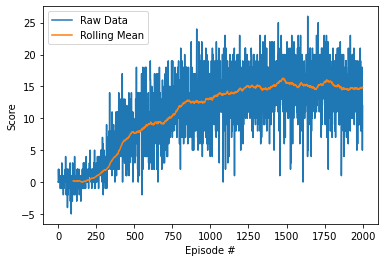

In [10]:
srpt_pens = []
qnet_name = "QNet_DDQNPER_SRPEN0"

agent_params = {'state_size': state_size,
                'action_size': action_size,
                'tor_dstate': tor_dstate,
                'srpt_pens': srpt_pens,
                'lrn_rate': 7.5e-5,
                'hsize1': 64,
                'hsize2': 64}

agent_train = DDQNPERAgent(**agent_params)

train_params = {'env': env,
                'agent': agent_train,
                'n_episodes': 2000,
                'print_every': 200,
                'beta_start': 1.0,
                'qnet_name': qnet_name}

scores = tt.train_ddqn_per(**train_params)
tt.plot_train_scores(scores)

##### Test the trained model

Test the trained model for 100 episodes and plot the scores and the score histogram. In addition to the score for each episode, the numbers of repeated states after 1, 2, 4, 6, 8, 10, and 12 actions are also obtained. The sum of these repeated state counts are plotted alongside the scores. Repeated states separated by fewer number of actions are more problematic for the DQN model since the slowly changing environment (the banana field in this case) will more likely break up the harmful loops of longer action sequences.

The repeated states after one action is likely caused by the agent hitting a wall or being very close to a wall and observing the same state after turning. Except such repeated states separated by 1 action, it is not likely for repeated states separated by odd number of actions to happen since the number of turns to complete a circle is even. So except repeated states separated by 1 action, only repeated states separated by even number of actions are checked.

In counting the occurances of repeated states, once a repeated state separated by a lower number of actions is counted; its repeat separated by higher number of actions won't be counted. For example, if the agent is stuck at a wall for a while, a new state resulting from the action that will keep it stucked will likely repeat the previous states separated by 1, 2, 3, and even more actions. In this case, only the repeated state separated by 1 action is counted.

Test Results: MeanScore =  16.04, MaxScore =  26, MinScore =   0


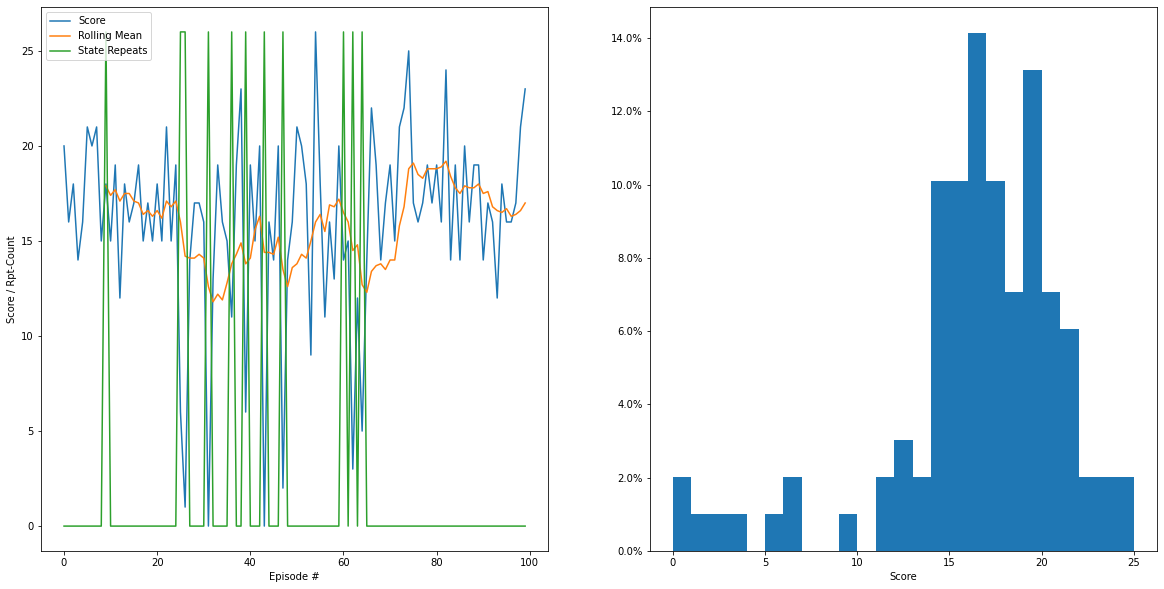

In [11]:
agent_test = DDQNPERAgent(**agent_params)
agent_test.load_qnet(qnet_name)
scores, n_rpts = tt.test_ddqn_per(env, agent_test, tor_dstate, n_episodes=100)
tt.plot_test_scores(scores, n_rpts)

##### Show details of the state repeat counts

The plot above shows strong correlation between low score and high state repeat count. The following plots separate the counts for the different number of actions between repeated states. The plots for repeated states after 1, 2, 4, and 6 to 12 actions are shown.

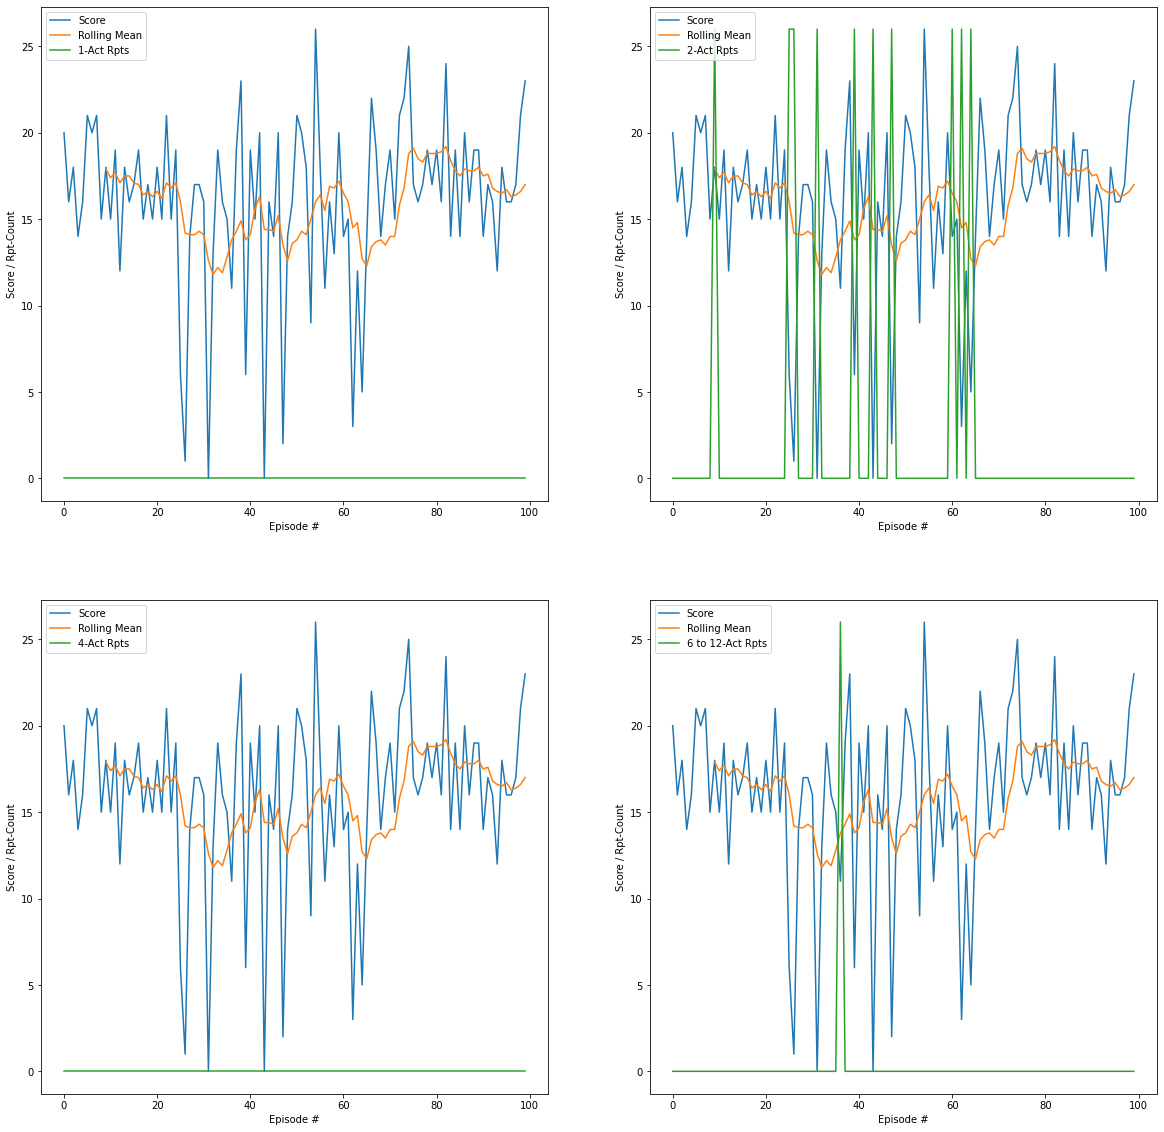

In [12]:
tt.plot_srpt_results(scores, n_rpts)

##### Post-process to remove repeated states

The detailed plots above show that repeated states after 2 actions caused most of the problems, but repeated states separated by other number of actions also happened occasionally and they may also be harmful to the agent in proventing it from obtaining higher scores.

Here a method for post-processing the actions ranked by the DQN's Q-values is used to avoid the actions causing the repeated states. This is achieved by tracking a short history of previous observed external states and the simulated internal states (x-y positions and orientations). Repeated states after 1 action can't be avoided outright. If it happened, the next action can be chosen by post-processing to avoid the continuation of the repeated state. With post-processing, repeated states separated by more than 1 action can be avoided.

In the following experiment, actions ranked by the DQN's Q-values are post-processed to avoid those that will continue the state repeat separated by 1 action and those that will cause state repeat separated by 2, 4, 6, 8, 10, and 12 actions. The types of undesirable actions to avoid is controlled by parameter, `post_srdet`, which is set to 7. So 7 types of undesirable actions (for continuing or causing repeated states separated by 1, 2, 4, 6, 8, 10, and 12 actions, respectively) are checked for avoidance.

Test Results: MeanScore =  16.80, MaxScore =  26, MinScore =   8


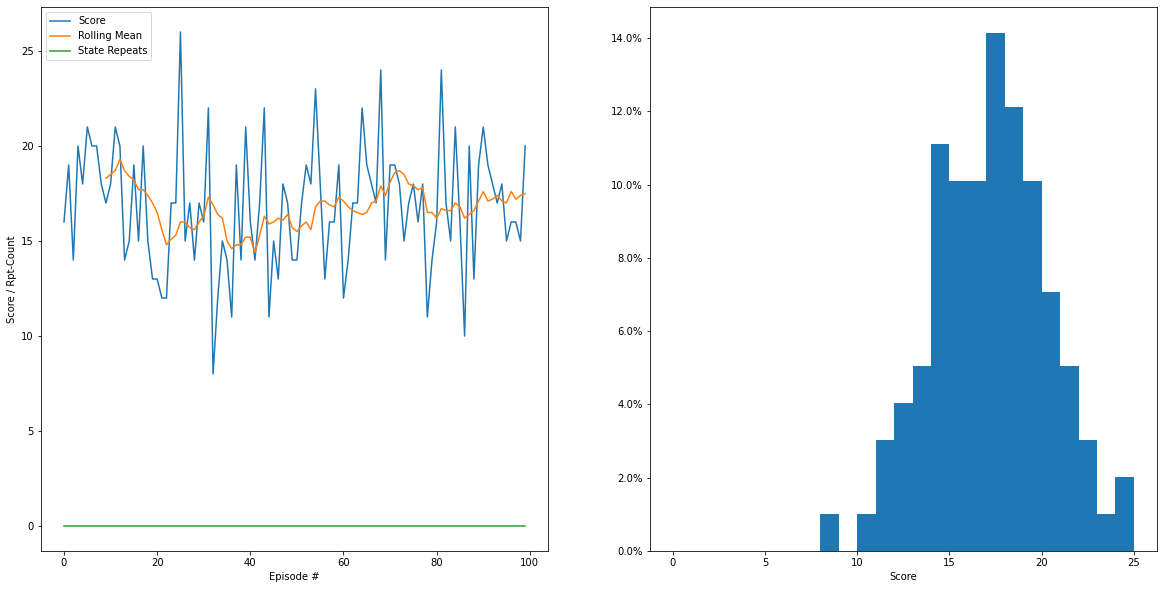

In [13]:
agent_test = DDQNPERAgent(**agent_params)
agent_test.load_qnet(qnet_name)
scores, n_rpts = tt.test_ddqn_per(env, agent_test, tor_dstate, n_episodes=100, post_srdet=7)
tt.plot_test_scores(scores, n_rpts)

#### D. Penalize Undesirable Actions by Augmenting State Vector and Modifying the Reward for Training

Results from above show that post-processing improved the mean testing score from 16.04 to 16.80 and the minimum score from 0 to 8. The improvement from post-processing is significant. The results also show that repeated states are eliminated.

Here a method for directly incorporating the mechanism for avoiding the undirable actions into the DQN is implemented and tested. Like post-processing, the undesirable actions are obtained by tracking a short history of previous observed external states and simulated internal states (x-y positions and orientations). Unlike post-processing, indicators for these undesirable actions are used to augment the input state vector to the DQN model. For each type of repeated state, with the type identified by the number of separating actions, an indicator vector of size 4 (number of possible actions) is added to the state vector. The values of the vector are 0 if there are no undesirable actions (i.e., no actions to avoid). If there is an undesirable action, the value at the vector position indexed by it is set to 1. To train the DQN with such an augmented state as input, if an undesirable action (which can be detected by the 1's in the indicator vectors added to the original state vector) is taken; a penalty value is used to modify the original reward stored in the experience replay buffer for training the model. If the original reward is 0, it will be assigned the negative penalty value to discourage the undesirable action.

In the experiment below, a list, `srpt_pens`, of 7 penalty values are used to discourage undesirable actions that will continue the repeated state separated by 1 action, and the actions that will cause repeated states separated by 2, 4, 6, 8, 10, and 12 actions, respectively.

Episode  200	Average Score:   1.63
Episode  400	Average Score:   8.55
Episode  600	Average Score:  11.76
Episode  800	Average Score:  13.32 (Best Solved Average Score:  13.54 at Episode  661!)
Episode 1000	Average Score:  15.55 (Best Solved Average Score:  15.68 at Episode  851!)
Episode 1200	Average Score:  15.62 (Best Solved Average Score:  16.55 at Episode  996!)
Episode 1400	Average Score:  16.48 (Best Solved Average Score:  16.80 at Episode 1260!)
Episode 1600	Average Score:  16.01 (Best Solved Average Score:  17.13 at Episode 1384!)
Episode 1800	Average Score:  15.70 (Best Solved Average Score:  17.13 at Episode 1384!)
Episode 2000	Average Score:  15.35 (Best Solved Average Score:  17.13 at Episode 1384!)
First Solved Average Score:  13.01 at Episode  581!


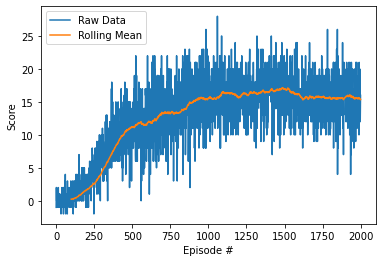

In [14]:
# Train the Double DQN model with augmented state vector and reward modified by penalizing undesirable actions.

srpt_pens = [-0.1, -0.1, -0.05, -0.05, -0.025, -0.025, -0.025]
qnet_name = "QNet_DDQNPER_SRPEN7"

agent_params = {'state_size': state_size,
                'action_size': action_size,
                'tor_dstate': tor_dstate,
                'srpt_pens': srpt_pens,
                'lrn_rate': 7.5e-5,
                'hsize1': 64,
                'hsize2': 64}

agent_train = DDQNPERAgent(**agent_params)

train_params = {'env': env,
                'agent': agent_train,
                'n_episodes': 2000,
                'print_every': 200,
                'beta_start': 1.0,
                'qnet_name': qnet_name}

scores = tt.train_ddqn_per(**train_params)
tt.plot_train_scores(scores)

Test Results: MeanScore =  16.74, MaxScore =  25, MinScore =  10


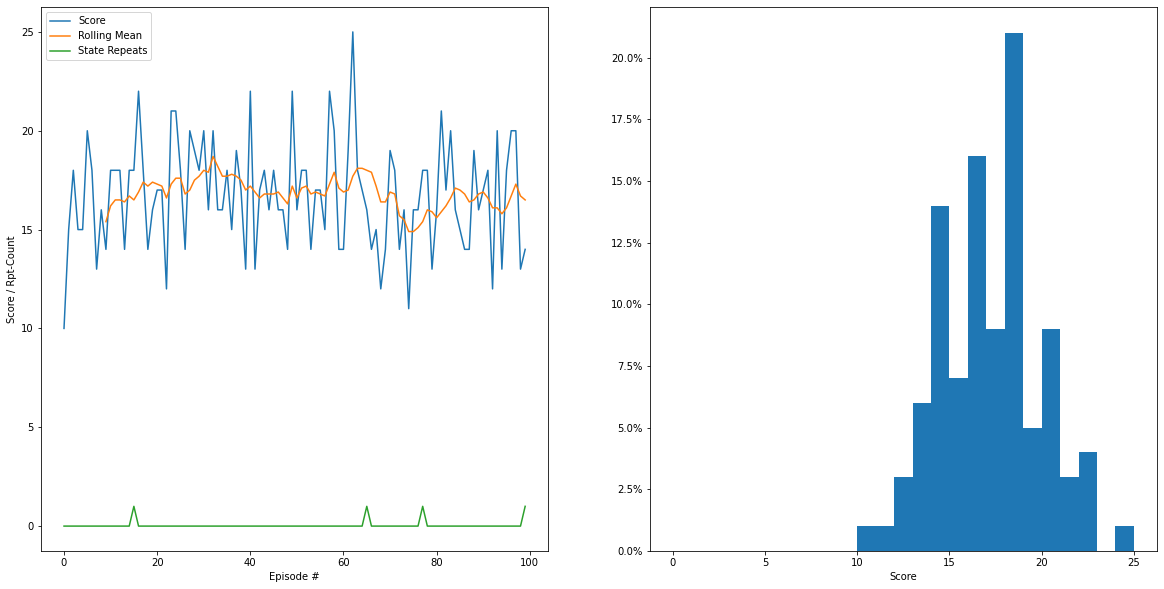

In [15]:
# Test the trained Double DQN model with augmented state vectors as inputs.

agent_test = DDQNPERAgent(**agent_params)
agent_test.load_qnet(qnet_name)
scores, n_rpts = tt.test_ddqn_per(env, agent_test, tor_dstate, n_episodes=100)
tt.plot_test_scores(scores, n_rpts)

#### E. Summarize the Experimental Results

The Double DQN model with Prioritized Experience Replay support is developed and tested. Experimental results show that the model can solve the environment (achieve average score of 13 or more) fairly quickly (in 871 episodes) and the best training score achieved within 2000 episodes is 16.27, which is quite good.

The mean testing score from the best trained model is 16.04, which is also good. However, test scores of some episodes are very low and even 0, which is not good. The examination of the repeated states shows strong correlation between low score and high state repeat counts. This verified a weakness of the DQN using only the current observed external state provided by the environment as the input to the model.

To help alleviate the problem caused by repeated states, a method is developed to track a short history of the observed external states and the simulated internal states (x-y positions and orientations). When such history is used to post-process the action rankings from the DQN during testing, the mean testing score improved from 16.04 to 16.80. More importantly, the minimum episode score improved from 0 to 8.

As an alternative to post-processing, a method is developed to use the short history to augment the state vector used as the input to the DQN. In training such a DQN with augmented state vector as input, the reward stored in the experience replay buffer is modified by penalty values to discourage the undesirable actions continuing or causing repeated states. Experimental results show that using such a DQN model with augmented input state vector, the environment can also be quickly solved (in 581 episodes) and the best training score achieved within 2000 episodes is 17.13, which is very good. The mean testing score of the best trained model is 16.74 with the minimum episode score being 10. The results also show that repeated states are mostly eliminated. Only large number of repeated states are problematic since they keep the agent in the same place for a long time, but a small number of repeated states are acceptable. So such an alternative Double DQN model with augmented input state vector achieved results comparable to those obtained by post-processing.

When finished, you can close the environment.

In [16]:
env.close()